# Vehicle Loan Default Prediction

This notebook consists of code used by me in Analytics Vidya's LTFS Data Science FinHack (ML Hackathon).
* Total Participants = 5667
* Final Public Score = 0.6472948090

**Setting up Google Colab.**

In [0]:
import tensorflow as tf 
device_name = tf.test.gpu_device_name() 
if device_name != '/device:GPU:0': raise SystemError('GPU device not found') 
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing the datasets from Google Drive**

In [0]:
# Uncompressing the dataset directly from Drive.
!unzip -qq '/content/drive/My Drive/Colab Notebooks/LTFS Data Science FinHack/Vehicle Loan Default Prediction/data/train.zip'
!unzip -qq '/content/drive/My Drive/Colab Notebooks/LTFS Data Science FinHack/Vehicle Loan Default Prediction/data/test.zip'

In [0]:
!cp '/content/drive/My Drive/Colab Notebooks/LTFS Data Science FinHack/Vehicle Loan Default Prediction/data/Data Dictionary.xlsx' 'Data Dictionary.xlsx'

In [0]:
# Listing the contents of the directory after uncompressing the dataset.
!ls

'Data Dictionary.xlsx'	 drive	 sample_data   test_bqCt9Pv.csv   train.csv


## Importing Libraries

In [0]:
import numpy as np
np.set_printoptions(precision=4)

import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = 50

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(10, 6))

In [0]:
from dateutil.parser import parse

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [0]:
import lightgbm as lgb

In [0]:
from tensorflow import keras

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [0]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

## Importing the training dataset

In [0]:
df = pd.read_csv('train.csv')
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


## Analyzing and Modifying the training dataset

In [0]:
# Checking the training dataset for any anomalies.
# Only the Employment.Type column has some missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
UniqueID                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
Date.of.Birth                          233154 non-null object
Employment.Type                        225493 non-null object
DisbursalDate                          233154 non-null object
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag                   

In [0]:
# Checking the number of missing values in Employment.Type column.
df['Employment.Type'].isnull().sum()

7661

In [0]:
# Creating a new column Employment.Type_No_NA with no NA values for Employment.Type
# Filling the NA values with 'No Information Available'.
df['Employment.Type_No_NA'] = df['Employment.Type'].fillna('No Information Available')

In [0]:
df['Employment.Type_No_NA'].value_counts()

Self employed               127635
Salaried                    97858 
No Information Available    7661  
Name: Employment.Type_No_NA, dtype: int64

In [0]:
df['Employment.Type_No_NA'].isnull().sum()

0

In [0]:
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Employment.Type_No_NA
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,Salaried
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,Self employed
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,Self employed
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,Self employed
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,Self employed


In [0]:
# Exploring the data dictionary of the dataset to analyze the description of the different features.
data_dict = pd.read_excel('Data Dictionary.xlsx')
data_dict

,Variable Name,Description,Unnamed: 2
0,UniqueID,Identifier for customers,NaN
1,loan_default,Payment default in the first EMI on due date,NaN
2,disbursed_amount,Amount of Loan disbursed,NaN
3,asset_cost,Cost of the Asset,NaN
4,ltv,Loan to Value of the asset,NaN
5,branch_id,Branch where the loan was disbursed,NaN
6,supplier_id,Vehicle Dealer where the loan was disbursed,NaN
7,manufacturer_id,"Vehicle manufacturer(Hero, Honda, TVS etc.)",NaN
8,Current_pincode,Current pincode of the customer,NaN
9,Date.of.Birth,Date of birth of the customer,NaN


In [0]:
# Exploring the columns containing categorical data.
# Checking the number of categories in PERFORM_CNS.SCORE.DESCRIPTION column.
len(df['PERFORM_CNS.SCORE.DESCRIPTION'].unique())

20

In [0]:
# Doing a value count on each category in PERFORM_CNS.SCORE.DESCRIPTION column.
df['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available                                116950
C-Very Low Risk                                            16045 
A-Very Low Risk                                            14124 
D-Very Low Risk                                            11358 
B-Very Low Risk                                            9201  
M-Very High Risk                                           8776  
F-Low Risk                                                 8485  
K-High Risk                                                8277  
H-Medium Risk                                              6855  
E-Low Risk                                                 5821  
I-Medium Risk                                              5557  
G-Low Risk                                                 3988  
Not Scored: Sufficient History Not Available               3765  
J-High Risk                                                3748  
Not Scored: Not Enough Info available on the customer      3672  
Not Scored

In [0]:
# Now working on columns containing data in an anomalous format.
# i.e. AVERAGE.ACCT.AGE and CREDIT.HISTORY.LENGTH columns.
# Creating new columns to convert the durations from a mixed format into months(integer format).
df['AVERAGE.ACCT.AGE_In_Months'] = (df['AVERAGE.ACCT.AGE'].str.extract('([0-9]+)yrs ([0-9]+)mon')[0].astype(int)   # Number of years
                                   * 12 
                                   + df['AVERAGE.ACCT.AGE'].str.extract('([0-9]+)yrs ([0-9]+)mon')[1].astype(int)) # Number of months

In [0]:
df['CREDIT.HISTORY.LENGTH_In_Months'] = (df['CREDIT.HISTORY.LENGTH'].str.extract('([0-9]+)yrs ([0-9]+)mon')[0].astype(int)   # Number of years
                                        * 12 
                                        + df['CREDIT.HISTORY.LENGTH'].str.extract('([0-9]+)yrs ([0-9]+)mon')[1].astype(int)) # Number of months

In [0]:
# Both the AVERAGE.ACCT.AGE_In_Months and CREDIT.HISTORY.LENGTH_In_Months columns contain the 
# AVERAGE.ACCT.AGE and CREDIT.HISTORY.LENGTH values respectively converted to months.
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Employment.Type_No_NA,AVERAGE.ACCT.AGE_In_Months,CREDIT.HISTORY.LENGTH_In_Months
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,Salaried,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,Self employed,23,23
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,Self employed,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,Self employed,8,15
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,Self employed,0,0


In [0]:
# Creating a function to extract Age of the customer form Date.of.Birth column.
def age_in_2019(date):
  dd = parse(date, dayfirst=True)
  if dd.year > 2018:
     dd = dd.replace(year=dd.year-100)
  age = 2019 - dd.year - ((((dd.month - 1) * 30) + dd.day) / 365)
  return age

In [0]:
# Creating a new feature with Customer's Age in 2019.
df['Customer_Age_In_2019'] = [age_in_2019(x) for x in df['Date.of.Birth']]
df['Customer_Age_In_2019'] = df['Customer_Age_In_2019'].round(3)
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Employment.Type_No_NA,AVERAGE.ACCT.AGE_In_Months,CREDIT.HISTORY.LENGTH_In_Months,Customer_Age_In_2019,DisbursalDate_Day,DisbursalDate_Month
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,Salaried,0,0,34.997,3,8
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,Self employed,23,23,33.422,26,9
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,Self employed,0,0,33.359,1,8
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,Self employed,8,15,25.014,26,10
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,Self employed,0,0,41.071,26,9


In [0]:
# Extracting date and month from DisbursalDate feature.
df['DisbursalDate_Day'] = [parse(x, dayfirst=True).day for x in df['DisbursalDate']]
df['DisbursalDate_Month'] = [parse(x, dayfirst=True).month for x in df['DisbursalDate']]
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Employment.Type_No_NA,AVERAGE.ACCT.AGE_In_Months,CREDIT.HISTORY.LENGTH_In_Months,Customer_Age_In_2019,DisbursalDate_Day,DisbursalDate_Month
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,Salaried,0,0,34.997,3,8
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,Self employed,23,23,33.422,26,9
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,Self employed,0,0,33.359,1,8
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,Self employed,8,15,25.014,26,10
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,Self employed,0,0,41.071,26,9


In [0]:
df['Customer_Age_In_2019'].isnull().sum()

0

In [0]:
df['DisbursalDate_Day'].isnull().sum()

0

In [0]:
len(df['DisbursalDate_Day'].unique())

31

In [0]:
df['DisbursalDate_Month'].isnull().sum()

0

In [0]:
df['DisbursalDate_Month'].value_counts()

10    98364
8     68002
9     66788
Name: DisbursalDate_Month, dtype: int64

## Exploratory Data Analysis

In [0]:
# Checking correlation between various features.
corr_mat = df.corr()
corr_mat

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,AVERAGE.ACCT.AGE_In_Months,CREDIT.HISTORY.LENGTH_In_Months,Customer_Age_In_2019,DisbursalDate_Day,DisbursalDate_Month
UniqueID,1.000000,0.145575,0.144671,-0.030537,-0.004509,0.025747,-0.021514,0.030500,-0.057734,0.075983,NaN,-0.001372,-0.014291,0.008201,-0.026072,-0.001382,-0.014016,-0.013584,-0.020862,-0.007915,-0.007259,-0.002910,-0.002563,-0.044180,-0.039888,-0.027486,-0.013428,-0.017114,-0.016857,-0.009321,-0.013518,-0.003842,-0.009186,0.016537,0.033848,-0.011912,-0.018799,0.005278,0.412364,0.934913
disbursed_amount,0.145575,1.000000,0.752668,0.376747,0.018328,0.078596,0.095203,0.068540,-0.023956,0.010120,NaN,-0.015589,0.014490,0.011665,0.001381,0.008291,0.011409,0.034461,0.039542,0.019422,0.015713,0.006294,0.006412,-0.014916,-0.014275,-0.007305,-0.004227,-0.005271,-0.005119,0.002350,-0.005525,0.035880,0.020198,0.038513,0.077675,0.004205,0.013402,-0.060454,0.024806,0.151983
asset_cost,0.144671,0.752668,1.000000,-0.301188,0.018586,0.150002,-0.005256,0.275878,-0.026348,0.008711,NaN,-0.093716,0.048075,0.083899,0.020484,0.005542,-0.047398,-0.026798,-0.021692,-0.014782,-0.004356,-0.001180,-0.001221,-0.022600,-0.020359,-0.013455,-0.008697,-0.010776,-0.010594,-0.004356,-0.005738,-0.021968,-0.007932,-0.017301,0.014261,-0.015614,-0.023563,-0.118358,0.019359,0.153871
ltv,-0.030537,0.376747,-0.301188,1.000000,0.006382,-0.103732,0.121003,-0.300112,0.004882,0.004940,NaN,0.106953,-0.037786,-0.098393,-0.024060,0.004467,0.084993,0.086571,0.087929,0.051770,0.026714,0.009955,0.010177,0.013019,0.010565,0.010256,0.007195,0.008800,0.008733,0.007358,0.000481,0.083824,0.041921,0.085725,0.098208,0.029853,0.053607,0.080107,-0.002435,-0.033832
branch_id,-0.004509,0.018328,0.018586,0.006382,1.000000,0.225744,-0.049957,0.048192,0.187782,0.088764,NaN,-0.036384,0.030206,0.021387,-0.015503,-0.008537,-0.018049,-0.010384,-0.006403,-0.005546,-0.004133,-0.003370,-0.003412,-0.003194,-0.001957,-0.007104,0.001418,0.002404,0.002457,0.004955,0.004265,-0.008354,-0.001730,-0.001813,0.030193,0.005338,-0.002577,-0.003116,0.007328,-0.007028
supplier_id,0.025747,0.078596,0.150002,-0.103732,0.225744,1.000000,-0.063916,0.187401,0.105502,0.095792,NaN,-0.081161,0.036804,0.079355,-0.015682,-0.008773,-0.077029,-0.070536,-0.066930,-0.042692,-0.022582,-0.012959,-0.012950,-0.025809,-0.019885,-0.015665,-0.008729,-0.010175,-0.010031,-0.011953,-0.005826,-0.053264,-0.024622,-0.030988,0.027357,-0.034095,-0.061370,-0.032962,0.007134,0.026613
manufacturer_id,-0.021514,0.095203,-0.005256,0.121003,-0.049957,-0.063916,1.000000,-0.104349,0.026412,-0.045009,NaN,0.041251,-0.029272,-0.046489,0.004777,0.016338,0.073012,0.068371,0.065589,0.025992,0.031722,0.017242,0.017080,0.008392,0.005898,0.008152,0.003106,0.003206,0.003301,0.014116,0.003020,0.050079,0.019438,0.010012,-0.025039,0.042522,0.061534,0.055115,-0.014184,-0.018907
Current_pincode_ID,0.030500,0.068540,0.275878,-0.300112,0.048192,0.187401,-0.104349,1.000000,0.047903,-0.042609,NaN,-0.309285,0.041118,0.281934,0.039667,-0.008913,-0.161664,-0.084687,-0.117882,-0.062177,-0.055948,-0.025843,-0.025697,-0.051766,-0.049852,-0.036228,-0.021048,-0.026059,-0.025630,0.002275,-0.006305,-0.100080,-0.057419,-0.058821,0.028419,-0.062704,-0.095906,-0.068061,-0.002951,0.032444
State_ID,-0.057734,-0.023956,-0.026348,0.004882,0.187782,0.105502,0.026412,0.047903,1.000000,0.117309,NaN,-0.169882,0.113939,0.151839,0.027886,-0.000915,-0.042323,-0.008704,-0.021061,-0.012381,-0.006359,-0.00430

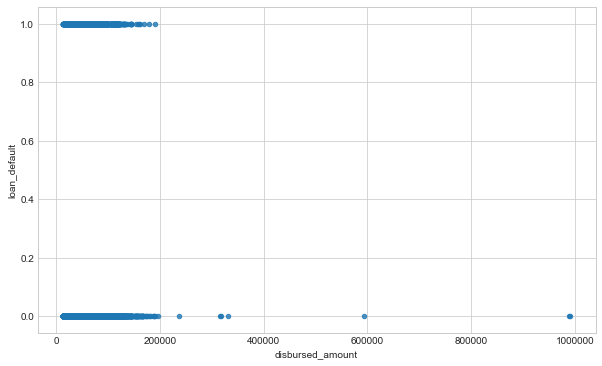

In [0]:
# For larger disbursed amount, loan default is low.
df.plot.scatter('disbursed_amount', 'loan_default', alpha=0.8)

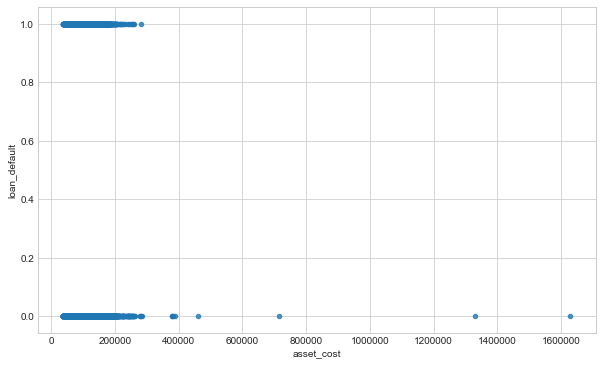

In [0]:
# For larger asset cost, loan default is low.
df.plot.scatter('asset_cost', 'loan_default', alpha=0.8)

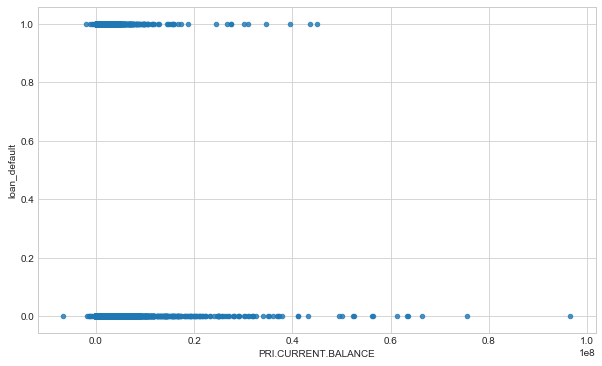

In [0]:
# For higher primary current balance, loan default is less.
df.plot.scatter('PRI.CURRENT.BALANCE', 'loan_default', alpha=0.8)

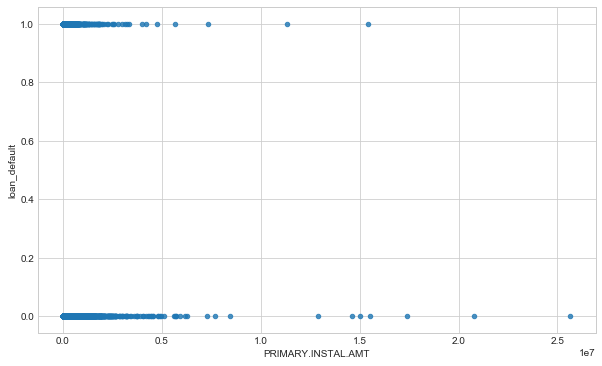

In [0]:
# Higher primary installment amount means lesser loan defaults.
df.plot.scatter('PRIMARY.INSTAL.AMT', 'loan_default', alpha=0.8)

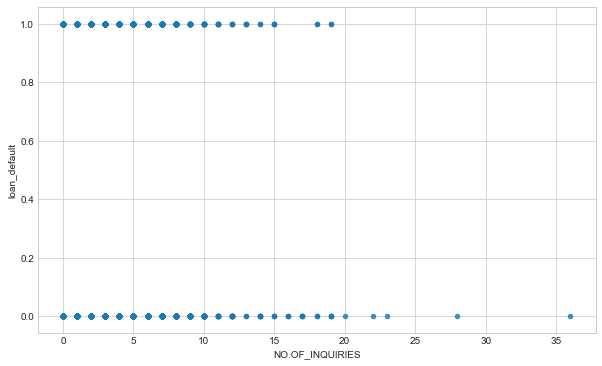

In [0]:
# For higher number of inquiries, loan default rate is lower.
df.plot.scatter('NO.OF_INQUIRIES', 'loan_default', alpha=0.8)

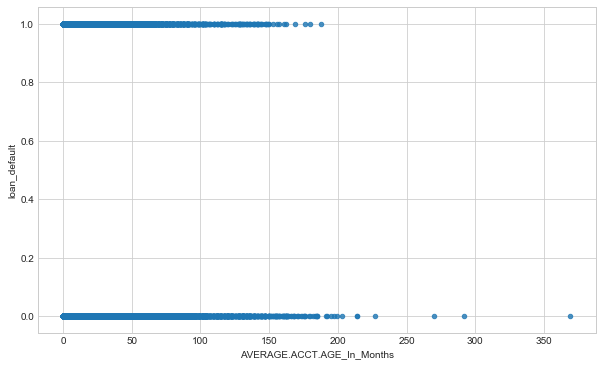

In [0]:
# Older the account, lesser are the chances of loan default.
df.plot.scatter('AVERAGE.ACCT.AGE_In_Months', 'loan_default', alpha=0.8)

## Importing the test dataset

In [0]:
df_test = pd.read_csv('test_bqCt9Pv.csv')
df_test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


## Analyzing and Modifying the test dataset

In [0]:
# Checking the test dataset for any anomalies.
# Only the Employment.Type column has some missing values.
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112392 entries, 0 to 112391
Data columns (total 40 columns):
UniqueID                               112392 non-null int64
disbursed_amount                       112392 non-null int64
asset_cost                             112392 non-null int64
ltv                                    112392 non-null float64
branch_id                              112392 non-null int64
supplier_id                            112392 non-null int64
manufacturer_id                        112392 non-null int64
Current_pincode_ID                     112392 non-null int64
Date.of.Birth                          112392 non-null object
Employment.Type                        108949 non-null object
DisbursalDate                          112392 non-null object
State_ID                               112392 non-null int64
Employee_code_ID                       112392 non-null int64
MobileNo_Avl_Flag                      112392 non-null int64
Aadhar_flag                   

In [0]:
# Checking the number of missing values in Employment.Type column.
df_test['Employment.Type'].isnull().sum()

3443

In [0]:
# Creating a new column Employment.Type_No_NA with no NA values for Employment.Type
# Filling the NA values with 'No Information Available'.
df_test['Employment.Type_No_NA'] = df_test['Employment.Type'].fillna('No Information Available')

In [0]:
df_test['Employment.Type_No_NA'].value_counts()

Self employed               59794
Salaried                    49155
No Information Available    3443 
Name: Employment.Type_No_NA, dtype: int64

In [0]:
df_test['Employment.Type_No_NA'].isnull().sum()

0

In [0]:
df_test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,Employment.Type_No_NA
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1,Self employed
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0,Self employed
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried


In [0]:
# Exploring the columns containing categorical data.
# Checking the number of categories in PERFORM_CNS.SCORE.DESCRIPTION column.
len(df_test['PERFORM_CNS.SCORE.DESCRIPTION'].unique())

19

In [0]:
# Doing a value count on each category in PERFORM_CNS.SCORE.DESCRIPTION column.
df_test['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available                                57893
C-Very Low Risk                                            7825 
A-Very Low Risk                                            7559 
D-Very Low Risk                                            5114 
B-Very Low Risk                                            4495 
M-Very High Risk                                           4032 
K-High Risk                                                3864 
F-Low Risk                                                 3691 
H-Medium Risk                                              3287 
I-Medium Risk                                              2703 
E-Low Risk                                                 2572 
G-Low Risk                                                 1807 
J-High Risk                                                1778 
Not Scored: No Activity seen on the customer (Inactive)    1361 
Not Scored: Not Enough Info available on the customer      1268 
Not Scored: Sufficient Hi

In [0]:
# Now working on columns containing data in an anomalous format.
# i.e. AVERAGE.ACCT.AGE and CREDIT.HISTORY.LENGTH columns.
# Creating new columns to convert the durations from a mixed format into months(integer format).
df_test['AVERAGE.ACCT.AGE_In_Months'] = (df_test['AVERAGE.ACCT.AGE'].str.extract('([0-9]+)yrs ([0-9]+)mon')[0].astype(int)    # Number of years
                                         * 12 
                                         + df_test['AVERAGE.ACCT.AGE'].str.extract('([0-9]+)yrs ([0-9]+)mon')[1].astype(int)) # Number of months

In [0]:
df_test['CREDIT.HISTORY.LENGTH_In_Months'] = (df_test['CREDIT.HISTORY.LENGTH'].str.extract('([0-9]+)yrs ([0-9]+)mon')[0].astype(int)    # Number of years
                                              * 12 
                                              + df_test['CREDIT.HISTORY.LENGTH'].str.extract('([0-9]+)yrs ([0-9]+)mon')[1].astype(int)) # Number of months

In [0]:
# Both the AVERAGE.ACCT.AGE_In_Months and CREDIT.HISTORY.LENGTH_In_Months columns contain the 
# AVERAGE.ACCT.AGE and CREDIT.HISTORY.LENGTH values respectively converted to months.
df_test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,Employment.Type_No_NA,AVERAGE.ACCT.AGE_In_Months,CREDIT.HISTORY.LENGTH_In_Months
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried,0,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1,Self employed,8,12
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried,0,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0,Self employed,29,29
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried,0,0


In [0]:
# Creating a new feature with Customer's Age in 2019.
df_test['Customer_Age_In_2019'] = [age_in_2019(x) for x in df_test['Date.of.Birth']]
df_test['Customer_Age_In_2019'] = df_test['Customer_Age_In_2019'].round(3)
df_test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,Employment.Type_No_NA,AVERAGE.ACCT.AGE_In_Months,CREDIT.HISTORY.LENGTH_In_Months,Customer_Age_In_2019,DisbursalDate_Day,DisbursalDate_Month
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried,0,0,44.997,3,11
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1,Self employed,8,12,33.616,20,11
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried,0,0,23.222,29,11
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0,Self employed,29,29,45.586,29,11
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried,0,0,46.586,17,11


In [0]:
# Extracting date and month from DisbursalDate feature.
df_test['DisbursalDate_Day'] = [parse(x, dayfirst=True).day for x in df_test['DisbursalDate']]
df_test['DisbursalDate_Month'] = [parse(x, dayfirst=True).month for x in df_test['DisbursalDate']]
df_test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,Employment.Type_No_NA,AVERAGE.ACCT.AGE_In_Months,CREDIT.HISTORY.LENGTH_In_Months,Customer_Age_In_2019,DisbursalDate_Day,DisbursalDate_Month
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried,0,0,44.997,3,11
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1,Self employed,8,12,33.616,20,11
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried,0,0,23.222,29,11
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0,Self employed,29,29,45.586,29,11
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,Salaried,0,0,46.586,17,11


In [0]:
df_test['Customer_Age_In_2019'].isnull().sum()

0

In [0]:
df_test['DisbursalDate_Day'].isnull().sum()

0

In [0]:
len(df_test['DisbursalDate_Day'].unique())

27

In [0]:
df_test['DisbursalDate_Month'].isnull().sum()

0

In [0]:
df_test['DisbursalDate_Month'].value_counts()

11    112392
Name: DisbursalDate_Month, dtype: int64

## Preparing a baseline model and Improving it

In [0]:
X = df.iloc[:, [1,2,3,4,5,6,7,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,39,41,42,43,44,45,46]].values

In [0]:
X[0]

array([50578, 58400, 89.55, 67, 22807, 45, 1441, 6, 1998, 1, 1, 0, 0, 0,
       0, 0, 'No Bureau History Available', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 'Salaried', 0, 0, 34.997, 3, 8], dtype=object)

In [0]:
y = df.iloc[:, 40].values
y

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [0]:
# Label Encoding various features.
labelencoder_PERFORM_CNS_SCORE_DESCRIPTION = LabelEncoder()
X[:, 16] = labelencoder_PERFORM_CNS_SCORE_DESCRIPTION.fit_transform(X[:, 16])

In [0]:
labelencoder_Employment_Type = LabelEncoder()
X[:, 34] = labelencoder_Employment_Type.fit_transform(X[:, 34])

In [0]:
X[0]

array([50578, 58400, 89.55, 67, 22807, 45, 1441, 6, 1998, 1, 1, 0, 0, 0,
       0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 34.997, 3, 8], dtype=object)

**Using a Random Forest Classifier**

In [0]:
# Creating a baseline Random Forest Classifier.
classifier_rf = RandomForestClassifier(n_estimators=200, random_state=42, oob_score=True, n_jobs=-1)

In [0]:
# Performing K-fold Cross-validation with 5 folds.
scores = cross_val_score(estimator=classifier_rf, X=X, y=y, cv=5, scoring='roc_auc')

In [0]:
scores

array([0.6363, 0.6028, 0.5927, 0.6179, 0.6035])

In [0]:
scores.mean()

0.6106200081997779

In [0]:
scores.std()

0.015142137334109882

In [0]:
# Fitting the model on whole dataset, for more train samples.
classifier_rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [0]:
# Classifier's score on the samples which were not seen by the Random Forest algorithm.
# oob_score works like a prediction on a validation or train set.
classifier_rf.oob_score_

0.7804198083670021

In [0]:
df.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'Employment.Type_No_NA', 'AVERAGE.ACCT.AGE_In_Months',
       'CREDIT.HISTORY.LENGTH_In_Months',

In [0]:
X_column_names = ['disbursed_amount', 'asset_cost', 'ltv', 'branch_id','supplier_id', 'manufacturer_id',
                  'Current_pincode_ID', 'State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag', 
                  'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag', 
                  'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 
                  'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 
                  'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
                  'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 
                  'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 
                  'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 
                  'NO.OF_INQUIRIES', 'Employment.Type_No_NA', 'AVERAGE.ACCT.AGE_In_Months', 
                  'CREDIT.HISTORY.LENGTH_In_Months', 'Customer_Age_In_2019', 'DisbursalDate_Day', 
                  'DisbursalDate_Month']

In [0]:
# Checking feature importances of various features.
for name, score in zip(X_column_names, classifier_rf.feature_importances_):
    print(name, score)

disbursed_amount 0.08621270208436385
asset_cost 0.08278093282878313
ltv 0.09172806651421045
branch_id 0.03922155079719259
supplier_id 0.06722062353788277
manufacturer_id 0.021498361866637686
Current_pincode_ID 0.08093142739319954
State_ID 0.024370212525564643
Employee_code_ID 0.07330107865849775
MobileNo_Avl_Flag 0.0
Aadhar_flag 0.005390430543080763
PAN_flag 0.005403313190838873
VoterID_flag 0.005474086937123908
Driving_flag 0.002572278263010553
Passport_flag 0.0003607081917123917
PERFORM_CNS.SCORE 0.023237638467345098
PERFORM_CNS.SCORE.DESCRIPTION 0.014490763987781523
PRI.NO.OF.ACCTS 0.01483825010480413
PRI.ACTIVE.ACCTS 0.008915791774179239
PRI.OVERDUE.ACCTS 0.0048111001944539334
PRI.CURRENT.BALANCE 0.022384911089959155
PRI.SANCTIONED.AMOUNT 0.02177839840868372
PRI.DISBURSED.AMOUNT 0.021699338825201
SEC.NO.OF.ACCTS 0.0016078188338476628
SEC.ACTIVE.ACCTS 0.0008475284388899532
SEC.OVERDUE.ACCTS 0.0005173560156477234
SEC.CURRENT.BALANCE 0.001051365532605184
SEC.SANCTIONED.AMOUNT 0.001176

In [0]:
# Feature Selection:
# Removing features with low feature importance.
# Removing MobileNo_Avl_Flag, Passport_flag, SEC.ACTIVE.ACCTS, SEC.OVERDUE.ACCTS, SEC.INSTAL.AMT
X_edit_rf = X[:, [0,1,2,3,4,5,6,7,8,10,11,12,13,15,16,17,18,19,20,21,22,23,26,27,28,29,31,32,33,34,35,36,37,38,39]]

In [0]:
X_edit_rf[0]

array([50578, 58400, 89.55, 67, 22807, 45, 1441, 6, 1998, 1, 0, 0, 0, 0,
       13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 34.997, 3,
       8], dtype=object)

In [0]:
# Performing K-fold Cross-validation with 5 folds.
scores = cross_val_score(estimator=classifier_rf, X=X_edit_rf, y=y, cv=5, scoring='roc_auc')

In [0]:
scores

array([0.6376, 0.6047, 0.5949, 0.6183, 0.6046])

In [0]:
scores.mean()

0.6120189575110088

In [0]:
scores.std()

0.014790908721100662

In [0]:
# Fitting the data to classifier.
classifier_rf.fit(X_edit_rf, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [0]:
classifier_rf.oob_score_

0.7811489401854568

In [0]:
# Creating an array with the most important features as per lgbm.
X_rf = X[:, [0,1,2,3,4,5,6,7,8,11,12,15,16,17,18,19,20,21,22,29,31,32,33,34,35,36,37,38,39]]

In [0]:
# Creating a new Random Forest Classifier to keep the results of previous classifier.
classifier_rf2 = RandomForestClassifier(n_estimators=200, random_state=42, oob_score=True, n_jobs=-1)

In [0]:
# Fitting the new X_rf array to the new classifier.
classifier_rf2.fit(X_rf, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [0]:
classifier_rf2.oob_score_

0.7811746742496376

**Using LGBM**

In [0]:
# Splitting the dataset into train and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# Performing Standardization of the train and val datasets.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [0]:
X_train_lgb = lgb.Dataset(X_train, label=y_train)

In [0]:
X_val_lgb = lgb.Dataset(X_val, label=y_val, reference=X_train_lgb)

In [0]:
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = ['binary_logloss', 'auc']
params['feature_fraction'] = 0.5
params['num_leaves'] = 31
params['min_data_in_leaf'] = 50
params['max_depth'] = 10

In [0]:
lgb_clf = lgb.train(params, X_train_lgb, 200, valid_sets=[X_val_lgb], early_stopping_rounds=20)

[1]	valid_0's auc: 0.602532	valid_0's binary_logloss: 0.521661
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.626895	valid_0's binary_logloss: 0.5192
[3]	valid_0's auc: 0.631787	valid_0's binary_logloss: 0.517487
[4]	valid_0's auc: 0.632023	valid_0's binary_logloss: 0.515905
[5]	valid_0's auc: 0.632652	valid_0's binary_logloss: 0.514851
[6]	valid_0's auc: 0.635869	valid_0's binary_logloss: 0.513262
[7]	valid_0's auc: 0.639484	valid_0's binary_logloss: 0.512026
[8]	valid_0's auc: 0.640221	valid_0's binary_logloss: 0.511176
[9]	valid_0's auc: 0.641892	valid_0's binary_logloss: 0.510065
[10]	valid_0's auc: 0.64374	valid_0's binary_logloss: 0.508824
[11]	valid_0's auc: 0.645791	valid_0's binary_logloss: 0.507992
[12]	valid_0's auc: 0.646054	valid_0's binary_logloss: 0.507076
[13]	valid_0's auc: 0.646635	valid_0's binary_logloss: 0.506328
[14]	valid_0's auc: 0.648145	valid_0's binary_logloss: 0.50572
[15]	valid_0's auc: 0.648162	valid_0's binary_logloss: 

In [0]:
lgb_clf.save_model('model.txt', num_iteration=lgb_clf.best_iteration)

In [0]:
# Loading the saved best model.
lgb_clf = lgb.Booster(model_file='model.txt')

In [0]:
# Checking feature importance.
for name, score in zip(X_column_names, lgb_clf.feature_importance()):
    print(name, score)

disbursed_amount 339
asset_cost 305
ltv 336
branch_id 266
supplier_id 400
manufacturer_id 108
Current_pincode_ID 532
State_ID 164
Employee_code_ID 425
MobileNo_Avl_Flag 0
Aadhar_flag 14
PAN_flag 31
VoterID_flag 32
Driving_flag 4
Passport_flag 8
PERFORM_CNS.SCORE 283
PERFORM_CNS.SCORE.DESCRIPTION 110
PRI.NO.OF.ACCTS 173
PRI.ACTIVE.ACCTS 94
PRI.OVERDUE.ACCTS 70
PRI.CURRENT.BALANCE 180
PRI.SANCTIONED.AMOUNT 177
PRI.DISBURSED.AMOUNT 135
SEC.NO.OF.ACCTS 11
SEC.ACTIVE.ACCTS 7
SEC.OVERDUE.ACCTS 8
SEC.CURRENT.BALANCE 15
SEC.SANCTIONED.AMOUNT 25
SEC.DISBURSED.AMOUNT 26
PRIMARY.INSTAL.AMT 213
SEC.INSTAL.AMT 22
NEW.ACCTS.IN.LAST.SIX.MONTHS 55
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS 71
NO.OF_INQUIRIES 72
Employment.Type_No_NA 80
AVERAGE.ACCT.AGE_In_Months 208
CREDIT.HISTORY.LENGTH_In_Months 194
Customer_Age_In_2019 334
DisbursalDate_Day 235
DisbursalDate_Month 118


In [0]:
# Feature Selection:
# Removing features with low feature importance.
# Removing MobileNo_Avl_Flag, Aadhar_flag, Driving_flag, Passport_flag, SEC.NO.OF.ACCTS, SEC.ACTIVE.ACCTS, SEC.OVERDUE.ACCTS, SEC.CURRENT.BALANCE, SEC.SANCTIONED.AMOUNT, SEC.DISBURSED.AMOUNT, SEC.INSTAL.AMT
X_edit_train = X_train[:, [0,1,2,3,4,5,6,7,8,11,12,15,16,17,18,19,20,21,22,29,31,32,33,34,35,36,37,38,39]]
X_edit_val = X_val[:, [0,1,2,3,4,5,6,7,8,11,12,15,16,17,18,19,20,21,22,29,31,32,33,34,35,36,37,38,39]]

In [0]:
X_edit_train_lgb = lgb.Dataset(X_edit_train, label=y_train)

In [0]:
X_edit_val_lgb = lgb.Dataset(X_edit_val, label=y_val, reference=X_train_lgb)

In [0]:
lgb_clf = lgb.train(params, X_edit_train_lgb, 200, valid_sets=[X_edit_val_lgb], early_stopping_rounds=20)

[1]	valid_0's auc: 0.606669	valid_0's binary_logloss: 0.521466
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.623224	valid_0's binary_logloss: 0.519198
[3]	valid_0's auc: 0.630037	valid_0's binary_logloss: 0.516985
[4]	valid_0's auc: 0.634046	valid_0's binary_logloss: 0.515174
[5]	valid_0's auc: 0.637585	valid_0's binary_logloss: 0.513751
[6]	valid_0's auc: 0.640365	valid_0's binary_logloss: 0.512396
[7]	valid_0's auc: 0.640756	valid_0's binary_logloss: 0.511133
[8]	valid_0's auc: 0.641502	valid_0's binary_logloss: 0.509868
[9]	valid_0's auc: 0.642427	valid_0's binary_logloss: 0.508771
[10]	valid_0's auc: 0.643316	valid_0's binary_logloss: 0.507875
[11]	valid_0's auc: 0.64411	valid_0's binary_logloss: 0.50694
[12]	valid_0's auc: 0.64486	valid_0's binary_logloss: 0.506158
[13]	valid_0's auc: 0.64563	valid_0's binary_logloss: 0.505542
[14]	valid_0's auc: 0.646441	valid_0's binary_logloss: 0.504973
[15]	valid_0's auc: 0.647265	valid_0's binary_logloss: 

In [0]:
lgb_clf.save_model('model2.txt', num_iteration=lgb_clf.best_iteration)

In [0]:
# Fine tuning the model hyperparameters. After many random guesses these parameters performed the best.
params['learning_rate'] = 0.05
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = ['binary_logloss', 'auc']
params['feature_fraction'] = 0.7
params['num_leaves'] = 31
params['min_data_in_leaf'] = 100
params['max_depth'] = 10
params['bagging_fraction'] = 0.8
params['bagging_freq'] = 5
params['lambda_l2'] = 0.2

In [0]:
lgb_clf = lgb.train(params, X_edit_train_lgb, 500, valid_sets=[X_edit_val_lgb], early_stopping_rounds=20)

[1]	valid_0's auc: 0.610935	valid_0's binary_logloss: 0.522647
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.627294	valid_0's binary_logloss: 0.52116
[3]	valid_0's auc: 0.629878	valid_0's binary_logloss: 0.519826
[4]	valid_0's auc: 0.630402	valid_0's binary_logloss: 0.518629
[5]	valid_0's auc: 0.632956	valid_0's binary_logloss: 0.51776
[6]	valid_0's auc: 0.633458	valid_0's binary_logloss: 0.516684
[7]	valid_0's auc: 0.633902	valid_0's binary_logloss: 0.515696
[8]	valid_0's auc: 0.63411	valid_0's binary_logloss: 0.514804
[9]	valid_0's auc: 0.634616	valid_0's binary_logloss: 0.513957
[10]	valid_0's auc: 0.635432	valid_0's binary_logloss: 0.513179
[11]	valid_0's auc: 0.6365	valid_0's binary_logloss: 0.512427
[12]	valid_0's auc: 0.637619	valid_0's binary_logloss: 0.511739
[13]	valid_0's auc: 0.638672	valid_0's binary_logloss: 0.511132
[14]	valid_0's auc: 0.639066	valid_0's binary_logloss: 0.510562
[15]	valid_0's auc: 0.639376	valid_0's binary_logloss: 0

In [0]:
lgb_clf.save_model('model.txt', num_iteration=lgb_clf.best_iteration)

In [0]:
X_lgb = X[:, [0,1,2,3,4,5,6,7,8,11,12,15,16,17,18,19,20,21,22,29,31,32,33,34,35,36,37,38,39]]

In [0]:
# Performing Standardization on the complete training set.
sc_lgb = StandardScaler()
X_lgb = sc_lgb.fit_transform(X_lgb)

In [0]:
X_lgb = lgb.Dataset(X_lgb, label=y)

In [0]:
# Fitting the whole training set into this classifier to get more training samples.
lgb_clf = lgb.train(params, X_lgb, 500)

In [0]:
# Saving the final model.
lgb_clf.save_model('model3.txt', num_iteration=lgb_clf.best_iteration)

In [0]:
# Loading the saved final model.
lgb_clf = lgb.Booster(model_file='model3.txt')

**Using ANN**

In [0]:
X_ann = X[:, [0,1,2,3,4,5,6,7,8,11,12,15,16,17,18,19,20,21,22,29,31,32,33,34,35,36,37,38,39]]

In [0]:
mms = MinMaxScaler()
X_ann = mms.fit_transform(X_ann)

In [0]:
X_ann.shape

(233154, 29)

In [0]:
# Making an ANN.
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(29,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 256)               7680      
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_28 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               65792     
__________

In [0]:
# Compiling the model
model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['acc'])

In [0]:
callback_list = [EarlyStopping(monitor='acc', patience=10)]

In [0]:
# Fitting the train set to the model
history = model.fit(X_ann, y, epochs=100, batch_size=256, validation_split=0.2, callbacks=callback_list)

Train on 186523 samples, validate on 46631 samples
Epoch 1/100
186523/186523 [==============================] - 4s 20us/step - loss: 0.4919 - acc: 0.7848 - val_loss: 0.5205 - val_acc: 0.7742
Epoch 2/100
186523/186523 [==============================] - 4s 20us/step - loss: 0.4909 - acc: 0.7851 - val_loss: 0.5193 - val_acc: 0.7745
Epoch 3/100
186523/186523 [==============================] - 4s 20us/step - loss: 0.4904 - acc: 0.7854 - val_loss: 0.5183 - val_acc: 0.7744
Epoch 4/100
186523/186523 [==============================] - 4s 20us/step - loss: 0.4896 - acc: 0.7855 - val_loss: 0.5179 - val_acc: 0.7744
Epoch 5/100
186523/186523 [==============================] - 4s 20us/step - loss: 0.4902 - acc: 0.7856 - val_loss: 0.5177 - val_acc: 0.7745
Epoch 6/100
186523/186523 [==============================] - 4s 20us/step - loss: 0.4896 - acc: 0.7855 - val_loss: 0.5175 - val_acc: 0.7747
Epoch 7/100
186523/186523 [==============================] - 4s 20us/step - loss: 0.4896 - acc: 0.7856 - val_

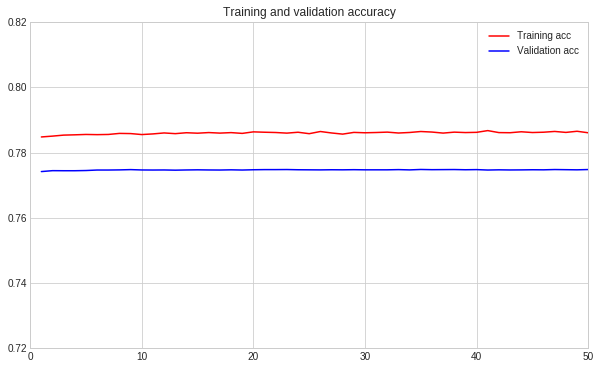

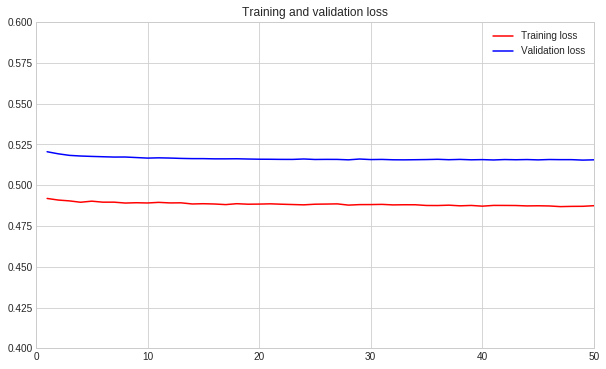

In [0]:
# Plotting training and validation accuracy and loss against epochs.
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.axis([0, 50, 0.72, 0.82])
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.axis([0, 50, 0.4, 0.6])
plt.legend()
plt.show()

In [0]:
# Fitting the model on complete training set.
model.fit(X_ann, y, epochs=100, batch_size=256, callbacks=callback_list)

Epoch 1/100
233154/233154 [==============================] - 4s 18us/step - loss: 0.4927 - acc: 0.7841
Epoch 2/100
233154/233154 [==============================] - 4s 19us/step - loss: 0.4929 - acc: 0.7838
Epoch 3/100
233154/233154 [==============================] - 4s 19us/step - loss: 0.4933 - acc: 0.7840
Epoch 4/100
233154/233154 [==============================] - 4s 19us/step - loss: 0.4931 - acc: 0.7838
Epoch 5/100
233154/233154 [==============================] - 4s 19us/step - loss: 0.4931 - acc: 0.7840
Epoch 6/100
233154/233154 [==============================] - 4s 19us/step - loss: 0.4928 - acc: 0.7839
Epoch 7/100
233154/233154 [==============================] - 5s 22us/step - loss: 0.4930 - acc: 0.7840
Epoch 8/100
233154/233154 [==============================] - 5s 21us/step - loss: 0.4927 - acc: 0.7841
Epoch 9/100
233154/233154 [==============================] - 4s 19us/step - loss: 0.4930 - acc: 0.7839
Epoch 10/100
233154/233154 [==============================] - 4s 19us/ste

## Making Predictions on the test set

In [0]:
X_test = df_test.iloc[:, [1,2,3,4,5,6,7,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,39,40,41,42,43,44,45]].values

In [0]:
X_test[0]

array([53478, 63558, 86.54, 67, 22807, 45, 1497, 6, 1998, 1, 1, 0, 0, 0,
       0, 0, 'No Bureau History Available', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 'Salaried', 0, 0, 44.997, 3, 11], dtype=object)

In [0]:
# Label Encoding various features.
X_test[:, 16] = labelencoder_PERFORM_CNS_SCORE_DESCRIPTION.transform(X_test[:, 16])

In [0]:
X_test[:, 34] = labelencoder_Employment_Type.transform(X_test[:, 34])

In [0]:
X_test[0]

array([53478, 63558, 86.54, 67, 22807, 45, 1497, 6, 1998, 1, 1, 0, 0, 0,
       0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 44.997, 3, 11], dtype=object)

In [0]:
# Removing less important features.
X_test_edit = X_test[:, [0,1,2,3,4,5,6,7,8,11,12,15,16,17,18,19,20,21,22,29,31,32,33,34,35,36,37,38,39]]

### Ensembling all the different Classifiers

**ANN**

In [0]:
X_test_ann = mms.transform(X_test_edit)

In [0]:
X_test_ann[0]

array([0.0411, 0.0167, 0.9004, 0.2538, 0.8602, 0.    , 0.2037, 0.2381,
       0.5264, 0.    , 0.    , 0.    , 0.6842, 0.    , 0.    , 0.    ,
       0.0647, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.5   ,
       0.    , 0.    , 0.5243, 0.0667, 1.5   ])

In [0]:
# Making Predictions using ANN model.
y_pred_ann = model.predict(X_test_ann)

In [0]:
y_pred_ann = y_pred_ann.reshape(-1)

In [0]:
y_pred_ann[:10]

array([0.2174, 0.4292, 0.3069, 0.4911, 0.3727, 0.4212, 0.3769, 0.2464,
       0.2922, 0.2755], dtype=float32)

**LGBM**

In [0]:
X_test_lgb = sc_lgb.transform(X_test_edit)

In [0]:
X_test_lgb[0]

array([-0.0678, -0.6496,  1.0294, -0.085 ,  0.9073, -1.0852, -0.8489,
       -0.2816,  0.4599, -0.2859, -0.4117, -0.8555,  0.674 , -0.4678,
       -0.5356, -0.2853, -0.1761, -0.092 , -0.0917, -0.0866, -0.3998,
       -0.2536, -0.2924, -0.9161, -0.5902, -0.5686,  1.0438, -2.0408,
        2.2403])

In [0]:
# Making Predictions using LGBM classifier.
y_pred_lgb = lgb_clf.predict(X_test_lgb)

In [0]:
y_pred_lgb[:10]

array([0.2428, 0.3141, 0.3393, 0.321 , 0.3071, 0.3312, 0.4416, 0.2775,
       0.3263, 0.3007])

In [0]:
# Converting into binary values.
'''
for i in range(0,112392):
  if y_pred_lgb[i] >= .5: # setting threshold to .5
    y_pred_lgb[i]=1
  else:
    y_pred_lgb[i]=0
'''

**Random Forest**

In [0]:
# Making Predictions using Random Forest classifier.
y_pred_rf = classifier_rf2.predict_proba(X_test_edit)[:, 1]

In [332]:
y_pred_rf[:10]

array([0.335, 0.235, 0.35 , 0.275, 0.3  , 0.335, 0.385, 0.255, 0.17 ,
       0.215])

**Ensembling**

In [0]:
# Giving weights to the different predictions.
# 45% weight to ANN because its most accurate, 30% to LGBM, 25% to Random Forest.
y_pred = (y_pred_ann * 0.45) + (y_pred_lgb * 0.3) + (y_pred_rf * 0.25)

In [343]:
y_pred[:10]

array([0.2544, 0.3461, 0.3274, 0.386 , 0.3349, 0.3727, 0.3984, 0.2578,
       0.2719, 0.2679])

In [335]:
# Extracting UniqueID column from test set.
unique_ID = df_test['UniqueID']
unique_ID[:10]

0    655269
1    723482
2    758529
3    763449
4    708663
5    725530
6    708592
7    714975
8    712795
9    708656
Name: UniqueID, dtype: int64

In [344]:
# Creating a dataframe as per the submission requirements for easy export to other formats.
pred_df = pd.DataFrame({'UniqueID': unique_ID, 'loan_default':y_pred})
pred_df.head()

,UniqueID,loan_default
0,655269,0.254413
1,723482,0.346101
2,758529,0.327395
3,763449,0.386033
4,708663,0.334856


In [0]:
# Exporting to csv format for submission.
pred_df.to_csv('/content/drive/My Drive/Colab Notebooks/LTFS Data Science FinHack/Vehicle Loan Default Prediction/data/Loan_Default_Predictions.csv', index=False)